# DCGAN 튜토리얼

## 개요 

예제를 통해 DCGAN에 대해서 알아보자. 
이 에제에선 실제 유명인들의 사진들로 GAN을 학습 시켜 새로운 유명인의 사진을 생성 시켜볼 것이다. 

## 적대적 생성 신경망(Generative Adversarial Networks)

GAN은 학습데이터들의 분포를 학습하여 같은 분포에서 새로운 데이터를 생성할 수 있도록 DL모델을 학습시키는 프레임워크를 뜻한다. 
GAN은 생성자와 구분자로 구별되는 두가지 모델을 가지고 있는것이 특징이다. 생성자는 실제이미지로 착갈할만큼 정교한 이미지를 만드는것이고 구분자는 이미지를 보고 생성자에 의해 생성된 이미지인지, 실제 이미지인지 구별하는것이다. 
모델을 학습하는동안 생성자는 더 정교한 이미지를 생성하여 구분자를 속이려하고 구분자는 더 정확히 이미지가 가짜인지 진짜인지를 구별할도록 노력한다. 

### 예제에서 사용할 구분자 정의 
- x : 이미지로 표현되는 데이터 
- D(x) : 구분자 신경망 -> 실제 학습데이터에서 가져온 x를 통과시켜 상수 확률값을 결과로 출력, 3x64x64 크기의 CHW 데이터를 입력받음. x가 학습데이터로부터 가져온것이면 출력이 크고, 생성자가 만든어낸 x일때 작음 
- z : 정규분포에서 뽑은 잠재공간 벡터(latent space vector)
- G(z) : z 벡터를 원하는 데이터 차원으로 대응시키는 신경망임. 
- D(G(Z)) : G가 출력한 결과물이 실제이미지일 0~1범위의 확률값


### GAN의 손실함수 
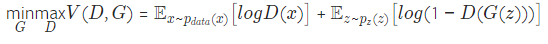



## DCGAN은 그럼 무엇인가?

GAN에서 파생된 모델로 생성자와 구분자에서 convolution과 convolution-transpose를 사용한 것이 차이점이다. 

이전 GAN모델과 구조적 차이점 
- 구분자에선 convolution layer, batch norm layer, LeakyReLU가 사용됨
- 생성자는 convolutin-transpose layer, batch norm layer, ReLU가 사용됨

- ** convolutin-transpose layer는 잠재공간벡터가 이미지와 같은 차원을 갖도록 변환하는 역활




In [1]:
from __future__ import print_function
#matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### 설정값 정의 

- dataroot : 데이터셋 폴더의 경로
- workers : DataLoader에서 데이터를 불러올 때 사용할 쓰레드수 개수
- batch_size : 학습에 사용할 배치 크기. DCGAN에선 128로 설정
- image_size : 학습에 사용하는 이미지의 크기 
- nc : 입력 이미지의 색 채널개수. RGB이미지이기 때문에 3으로 설정 
- nz : 잠재공간 벡터의 원소 개수 
- ngf : 생성자를 통과할 때 만들어질 특징 데이터 채널개수 
- ndf : 구분자를 통과할 때 만들어질 특징 데이터 채널개수
- num_epochs : 학습시킬 에폭수
- lr : 학습률 
- beta1 : Adam 옵티마이저에서 사용할 beta1하이퍼파라미터 값. 0.5로 설정 
- ngpu : 사용가능한 GPU 번호. 0이면 cpu로 학습, 0보다 크면 각 숫자의 GPU로 학습


In [2]:
dataroot = '../input/celeba'
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz =100
ngf = 64
ndf = 64
num_epochs = 5 
lr = 0.0002
beta1 = 0.5
ngpu = 1

## 데이터 

Celeb-A Faces dataset 

In [3]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,
                                         normalize=True).cpu(),(1,2,0)))

## 구현 
1. 가중치 초기화
2. 생성자 
3. 구분자
4. 손실함수
5. 학습방법
순서로 진행 

## 가중치 초기화

DCGAN 논문에서 평균이 0이고 분산이 0.02인 정규분포를 이용해 구분자와 생성자 모두 초기화를 하는것이 바람직하다고 한다. weights_init함수는 파라미터로 모델을 입력받아 모든 convolution layer, convolution-transpose layer, batch-norm layer를 앞서 언급한 방식으로 가중치를 다시 초기화한다. 아래의 함수로 모델이 만들어지자 마자 바로 적용을 한다.  

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 생성자

생성자 G는 잠재공간 벡터 z를 학습 이미지와 같은 사이즈를 가진 RGB이미지를 생성하는것과 같다. (예. 3x64x64).
실제 모델을에선 2 스트라이드를 가진 전치 합성곱 계층들을 이어서 구성하는데 각 전치 합성곱 계층 하나다 2차원 배치 정규화 계층과 relu활성 함수를 한쌍으로 묶어서 사용한다. 마지막 출력 계층에서 데이터를 tanh함수에 통과시켜 출력값은 [-1,1]의 범위로 조정한다.

아래의 그림은 DCGAN 논문에서의 생성자의 모델 구조이다. 
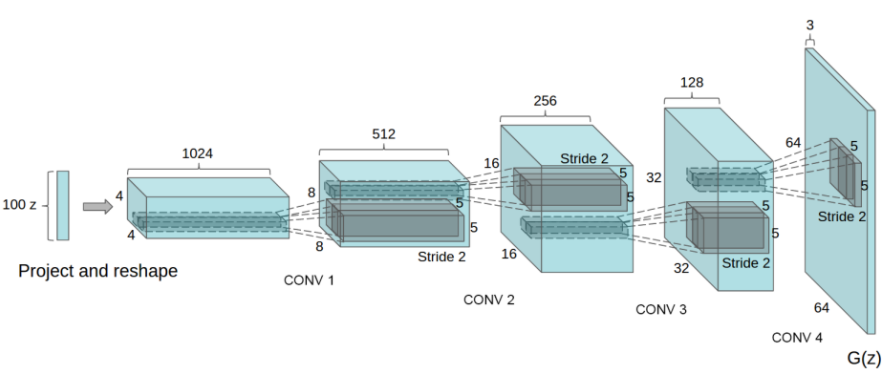

In [20]:
# 생성자 코드
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf* 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)

In [21]:
# 생성자 만들기
netG = Generator(ngpu).to(device)

# 필요할 경우 multi-gpu 설정 
if(device.type =='cuda') and (ngpu>1):
    netG == nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0 분산을 0.02로 초기화하기 위해 weight_init 함수 적용
netG.apply(weights_init)

print(netG)

## 구분자 

구분자는 3x64x64 크기의 이미지를 입력 받아 convolution layer, Batch Norm, Leaky ReLU layer를 통과시켜 데이터를 가공하여 마지막 출력에서 sigmoid 함수를 이용하여 0~1사이의 확률값으로 조정한다. DCGAN 논문에서는 stride가 있는 convolution layer 사용하는것이 신경망내에서 스스로 풀링 함수를 학습하기 때문에 직접적으로 풀링계층을 사용하는것이 더 유리하다고 한다. 

In [40]:
#구분자 코드 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)


# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

In [41]:
# 구분자 만들기 
netD = Discriminator(ngpu).to(device)

# 필요할 경우 multi-gpu 설정 
if(device.type =='cuda') and (ngpu>1):
    netD == nn.DataParallel(netD, list(range(ngpu)))
    
# 모든 가중치의 평균을 0 분산을 0.02로 초기화하기 위해 weight_init 함수 적용
netD.apply(weights_init)

print(netD)

## 손실함수와 옵티마이저 

손실함수로는 Binary Cross Entropy loss를 사용한다. 

In [29]:
# BCELoss 함수 인스턴스 생성 
criterion = nn.BCELoss()

# 생성자의 학습 상태를 확인할 잠재공간 벡터 생성
fixed_noise = torch.randn(64, nz,1,1, device=device)

# 학습에 사용되는 라벨 설정 
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 학습

이번 튜토리얼에서는 Goodfellow의 논문에서 서술된 1번 알고리즘을 기반으로 ganhacks에서 사용된 몇가지 테크닉을 추가할것이다. 여기서 원하는 바는 진짜 혹은 가짜 이미지를 구성하고 , logD(G(z))를 최대화 하는 목적함수를 최적화 하는 것이다.

#### 학습 과정은 크게 두개로 나뉜다.
1. PART_1 구분자 학습 및 업데이트
- 구분자의 목적: 입력값이 진짜인지 가짜인지 판별
- 구분자는 gradient ascent를 하며 훈련한다 -> log(D(x)) + log(1-D(G(z)))를 최대화 시키는것
- ganhacks에서 미니배치를 분리하여 사용한 개년대로 이번 예제에서도 두가지 스텝으로 분리해 계산할 것이다.

    1) 진짜 데이터로 이루어진 배치를 만들어 D에 통과 시킨다. 그 출력값으로 (log(D(x)))의 손실값을 계산하고 역전파 과정에서 변화도를 계산한다.
    2) 가짜 데이터로 이루어진 배치를 만들어 D에 통과시키고 log(1-D(G(z)))의 손실값을 계산해 역전파 변화도를 구한다.
    ** 이 두 과정에서 변화도들은 축적시켜야 한다.

 
2. PART_2 생성자 학습 및 업데이트 
- 오리지널 GAN논문에서는 생성자는 log(1-D(G(z)))를 최소화 하는 방향으로 학습한다. 하지만 이 방식은 충분한 변화도를 제공하지 못하는 문제점이 있다. 그래서 이를 극복하기 위해 log(D(G(z)))를 최대화하는 방식으로 바꿔서 학습을 진행한다. 이것을 코드로 구현하기 위해서 PART_1에서 한것처럼 구분자를 이용해 생성자의 출력값을 판별하고 진짜 라벨값을 이용하여 G의 손실값을 구한다. 이를 기반으로 변화도를 구하고 옵티마이저를 이용해 G의 가중치를 업데이트 하면 된다. 

** G의 훈련상태를 확인하기 위해 몇개의 통계적인 수치와 fixed_noise를 통과시킨 결과를 화면에 출력하는 코드를 추가한다.

Loss_D : 진짜 데이터와 가짜데이터 모두에서 구한 손실값 (logD(x)) + log(1-D(G(z)))
Loss_G : 생성자의 손실값 log(D(G(z)))
D(x) : 구분자가 데이터를 판별한 확률값. 초기에는 1에 가까운 값이다가 G가 학습을 진행할수록 0.5값에 수렴
D(G(z)) : 가짜 데이터들에 대한 구분자의 출력값. 초기에는 0에 가까운 값이다가 G가 학습을 진행할수록 0.5값에 수렴

In [48]:
# 학습 과정

# 학습 상태를 모니터하기 위해 손실값을 저장 
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭 반복 
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복 
    for i, data in enumerate(dataloader, 0):
        ###################
        # (1) D 신경망을 업데이트 : log(D(x)) + log(1 - D(G(z)))를 최대화
        ###################
        ## 진짜 데이터 학습
        netD.zero_grad()
        # 배치 사이즈와 디바이스 맞게 설정 
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터 배치를 D에 통과
        output = netD(real_cpu).view(-1)
        # 손실값 계산
        errD_real = criterion(output, label)
        # 역전파 과정에서 변화도 계산 
        errD_real.backward()
        D_x = output.mean().item()
        
        ## 가짜데이터 학습 
        # 생성자에 사용할 잠재공간 벡터 생성 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지 생성 
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용행 데이터의 진위 판별
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        ##가짜 이미지와 진짜 이미지 모두에서 구한 손실 값을 더함 
        # 이 때 errD는 역전파에 사용되지 않고 이후 학습상태를 리포팅 할 때 사용
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ##########################
        # (2) G신경망을 업데이트 : log(D(G(z)))를 최대화 합니다
        ##########################
        netG.zero_grad()
        # 생성자의 손실값을 구하기 위해 진짜 라벨 사용    
        label.fill_(real_label)
        
        # 좀 전에 D를 없데이트 했기 때문에 D에 다시 가짜 데이터를 통과
        # 이때 G는 업데이트 되지 않았지만, D가 업데이트 됐기 떄문에 앞선 손실값과 다른값이 나옴
        output = netD(fake).view(-1)
        # G의 손실값을 구함 
        errG = criterion(output, label)
        # G의 변화도 계산 
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트
        optimizerG.step()


        
        # 훈련상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                 % (epoch, num_epochs, i, len(dataloader),
                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # 이후 그래프를 그리기 위해 손실값 저장 
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        #fixed_noise를 통과시킨 G의 출력값을 저장 
        if (iters % 500==0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

## 결과 

결과 확인 단계에선 아래 3가지를 확인한다.
1. G와 D의 손실값 변화 확인
2. 매 에폭마다 fixed_noise를 이용해 G가 만들어낸 이미지 
3. 학습이 끝난 G가 만들어낸 이미지와 진짜이미지 비교 

### 1. 학습하는 동안의 손실값들

In [49]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel("Loss")
plt.legend()
plt.show()

### 2. G의 학습 과정 시각화

In [50]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### 3. 진짜 이미지 vs 가짜 이미지

In [51]:
# dataloader에서 진짜 데이터들을 가져온다.
real_batch = next(iter(dataloader))

# 진짜 이미지 출력
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], paddinig=5,
                                        normalized=True).cpu(),(1,2,0)))
# 가짜 이미지 출력
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()